In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import local modules
from simulation import generate_sequence, sample_spatial, sample_temporal
from config import BaselineConfig, VisualizationConfig

ImportError: cannot import name 'sample_spatial' from 'simulation' (/Users/apple/git/neuro/OpenSTL/experiments/baseline_simulation/simulation.py)

In [ ]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

In [ ]:
# Load configuration
config = BaselineConfig()
vis_config = VisualizationConfig()

In [ ]:
print("Configuration Summary:")
config.print_config()

Configuration Summary:
Baseline Simulation Configuration:
  Sequence length (T): 32
  Image size: 32x32
  Spatial sigma: 5.0
  Temporal p: 0.4
  Expected duration: 2.50 frames
  Expected fixations: 12.8
  Batch sizes - Train: 100, Val: 20, Test: 20


In [ ]:
# Load generated data files
data_files = {
    'baseline': 'data/baseline_data.pt',
    'train': 'data/train_data.pt',
    'val': 'data/val_data.pt',
    'test': 'data/test_data.pt'
}

In [ ]:
loaded_data = {}
for name, filepath in data_files.items():
    try:
        data = torch.load(filepath)
        loaded_data[name] = data
        print(f"✅ {name}: {data.shape}")
    except FileNotFoundError:
        print(f"❌ {name}: File not found - {filepath}")

✅ baseline: torch.Size([16, 32, 1, 32, 32])
✅ train: torch.Size([100, 32, 1, 32, 32])
✅ val: torch.Size([20, 32, 1, 32, 32])
✅ test: torch.Size([20, 32, 1, 32, 32])


In [ ]:
def create_sample_analysis_gif():
    """Create an analysis GIF showing eye movement patterns."""
    
    print("\n=== Creating Sample Analysis GIF ===")
    
    # Generate a sample sequence for GIF
    sample_data = generate_sequence(1, config.T, config.IMG_SIZE, config.SIGMA, config.P)
    sequence = sample_data[0, :, 0, :, :].numpy()  # Shape: (T, H, W)
    T, H, W = sequence.shape
    
    print(f"Sequence shape: {sequence.shape}")
    print(f"Frames with fixations: {np.sum(sequence.sum(axis=(1,2)) > 0)}")
    
    # Find fixation coordinates
    fixations = []
    for t in range(T):
        frame = sequence[t]
        if frame.sum() > 0:
            y, x = np.where(frame > 0)
            if len(x) > 0 and len(y) > 0:
                fixations.append((x[0], y[0]))
            else:
                fixations.append(None)
        else:
            fixations.append(None)
    
    # Calculate fixation durations
    durations = []
    current_duration = 1
    prev_fixation = None
    
    for fixation in fixations:
        if fixation == prev_fixation:
            current_duration += 1
        else:
            if prev_fixation is not None:
                durations.append(current_duration)
            current_duration = 1
        prev_fixation = fixation
    
    if current_duration > 0:
        durations.append(current_duration)
    
    print(f"Fixation durations: {durations}")
    print(f"Total unique fixations: {len(durations)}")
    print(f"Mean duration: {np.mean(durations):.2f} frames")
    
    # Create static visualization instead of GIF for notebook
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Sequence Analysis - Key Frames', fontsize=16)
    
    # Show 8 key frames
    key_frames = np.linspace(0, T-1, 8, dtype=int)
    
    for i, frame_idx in enumerate(key_frames):
        ax = axes[i//4, i%4]
        
        # Show frame
        ax.imshow(sequence[frame_idx], cmap='Reds', alpha=0.7, origin='lower')
        
        # Show trajectory up to this frame
        valid_fixations = [(x, y) for x, y in fixations[:frame_idx+1] if x is not None]
        if len(valid_fixations) > 1:
            xs, ys = zip(*valid_fixations)
            ax.plot(xs, ys, 'b-', alpha=0.5, linewidth=2)
        
        # Highlight current fixation
        if fixations[frame_idx] is not None:
            x, y = fixations[frame_idx]
            ax.plot(x, y, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=2)
        
        ax.set_xlim(0, W)
        ax.set_ylim(0, H)
        ax.set_title(f'Frame {frame_idx+1}/{T}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_frame_lengths_detailed(data, title="Frame Length Analysis"):
    """Comprehensive frame length analysis with visualization."""
    
    print(f"\n=== {title} ===")
    batch_size, T, channels, height, width = data.shape
    print(f"Analyzing data shape: {data.shape}")
    
    # Extract frame lengths for each sequence
    all_frame_lengths = []
    sequence_stats = []
    
    for batch_idx in range(batch_size):
        sequence = data[batch_idx]  # Shape: (T, 1, height, width)
        
        # Find consecutive frames with same fixation
        frame_lengths = []
        current_length = 1
        prev_coords = None
        
        for t in range(T):
            frame = sequence[t, 0]  # Get 2D frame
            y_coords, x_coords = torch.where(frame > 0)
            
            if len(x_coords) > 0:
                current_coords = (x_coords[0].item(), y_coords[0].item())
                
                if prev_coords is not None:
                    if current_coords == prev_coords:
                        # Same fixation continues
                        current_length += 1
                    else:
                        # New fixation starts
                        frame_lengths.append(current_length)
                        current_length = 1
                
                prev_coords = current_coords
        
        # Add the last fixation length
        if current_length > 0:
            frame_lengths.append(current_length)
        
        all_frame_lengths.extend(frame_lengths)
        sequence_stats.append({
            'sequence_idx': batch_idx,
            'num_fixations': len(frame_lengths),
            'frame_lengths': frame_lengths,
            'mean_length': np.mean(frame_lengths),
            'total_frames': sum(frame_lengths)
        })
    
    # Convert to numpy for analysis
    all_frame_lengths = np.array(all_frame_lengths)
    
    # Print statistics
    print(f"\nFrame Length Statistics:")
    print(f"  Total fixations: {len(all_frame_lengths)}")
    print(f"  Mean length: {all_frame_lengths.mean():.2f} frames")
    print(f"  Std length: {all_frame_lengths.std():.2f} frames")
    print(f"  Min/Max length: {all_frame_lengths.min()}/{all_frame_lengths.max()} frames")
    print(f"  Median length: {np.median(all_frame_lengths):.2f} frames")
    print(f"  Expected (1/p={config.P}): {1/config.P:.2f} frames")
    
    # Show example sequences
    print(f"\nExample Sequences (first 5):")
    for i, stats in enumerate(sequence_stats[:5]):
        print(f"  Seq {i}: {stats['num_fixations']} fixations, "
              f"lengths {stats['frame_lengths']}, mean {stats['mean_length']:.2f}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{title} - Comprehensive Analysis', fontsize=16)
    
    # 1. Frame length histogram
    axes[0, 0].hist(all_frame_lengths, bins=range(1, max(all_frame_lengths)+2), 
                   alpha=0.7, density=True, edgecolor='black', color='skyblue')
    axes[0, 0].axvline(all_frame_lengths.mean(), color='red', linestyle='--', 
                      label=f'Mean: {all_frame_lengths.mean():.2f}')
    axes[0, 0].axvline(1/config.P, color='orange', linestyle='--', 
                      label=f'Expected: {1/config.P:.2f}')
    axes[0, 0].set_xlabel('Frame Length')
    axes[0, 0].set_ylabel('Probability')
    axes[0, 0].set_title('Frame Length Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Number of fixations per sequence
    num_fixations = [stats['num_fixations'] for stats in sequence_stats]
    axes[0, 1].hist(num_fixations, bins=range(min(num_fixations), max(num_fixations)+2),
                   alpha=0.7, density=True, edgecolor='black', color='lightgreen')
    axes[0, 1].axvline(np.mean(num_fixations), color='red', linestyle='--',
                      label=f'Mean: {np.mean(num_fixations):.1f}')
    axes[0, 1].axvline(config.T * config.P, color='orange', linestyle='--',
                      label=f'Expected: {config.T * config.P:.1f}')
    axes[0, 1].set_xlabel('Number of Fixations per Sequence')
    axes[0, 1].set_ylabel('Probability')
    axes[0, 1].set_title('Fixations per Sequence')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot of frame lengths
    axes[0, 2].boxplot(all_frame_lengths, patch_artist=True,
                      boxprops=dict(facecolor='lightcoral'))
    axes[0, 2].set_ylabel('Frame Length')
    axes[0, 2].set_title('Frame Length Distribution (Box Plot)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Frame length vs position in sequence
    for i, stats in enumerate(sequence_stats[:10]):  # Show first 10 sequences
        positions = range(1, len(stats['frame_lengths'])+1)
        axes[1, 0].plot(positions, stats['frame_lengths'], 'o-', alpha=0.6, 
                       linewidth=1, markersize=3)
    axes[1, 0].set_xlabel('Fixation Position in Sequence')
    axes[1, 0].set_ylabel('Frame Length')
    axes[1, 0].set_title('Frame Length vs Position (10 sequences)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Cumulative distribution
    sorted_lengths = np.sort(all_frame_lengths)
    cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    axes[1, 1].plot(sorted_lengths, cumulative, linewidth=2, color='purple')
    axes[1, 1].axvline(all_frame_lengths.mean(), color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_xlabel('Frame Length')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Sequence length validation
    total_frames = [stats['total_frames'] for stats in sequence_stats]
    axes[1, 2].hist(total_frames, bins=range(min(total_frames), max(total_frames)+2),
                   alpha=0.7, edgecolor='black', color='gold')
    axes[1, 2].axvline(config.T, color='red', linestyle='--', linewidth=2,
                      label=f'Target T={config.T}')
    axes[1, 2].set_xlabel('Total Frames per Sequence')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Sequence Length Validation')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'all_lengths': all_frame_lengths,
        'sequence_stats': sequence_stats,
        'summary': {
            'mean': all_frame_lengths.mean(),
            'std': all_frame_lengths.std(),
            'min': all_frame_lengths.min(),
            'max': all_frame_lengths.max(),
            'median': np.median(all_frame_lengths),
            'total_fixations': len(all_frame_lengths),
            'mean_fixations_per_seq': np.mean(num_fixations)
        }
    }


=== Baseline Data Frame Length Analysis ===
Analyzing data shape: torch.Size([16, 32, 1, 32, 32])

Frame Length Statistics:
  Total fixations: 202
  Mean length: 2.53 frames
  Std length: 2.08 frames
  Min/Max length: 1/15 frames
  Median length: 2.00 frames
  Expected (1/p=0.4): 2.50 frames

Example Sequences (first 5):
  Seq 0: 15 fixations, lengths [2, 1, 3, 2, 3, 3, 1, 1, 2, 1, 3, 1, 3, 5, 1], mean 2.13
  Seq 1: 13 fixations, lengths [1, 2, 1, 1, 4, 3, 4, 2, 1, 3, 3, 6, 1], mean 2.46
  Seq 2: 14 fixations, lengths [2, 1, 7, 1, 2, 2, 1, 1, 3, 1, 2, 1, 7, 1], mean 2.29
  Seq 3: 9 fixations, lengths [7, 2, 3, 2, 10, 1, 1, 5, 1], mean 3.56
  Seq 4: 13 fixations, lengths [2, 1, 2, 2, 5, 1, 2, 10, 2, 1, 2, 1, 1], mean 2.46


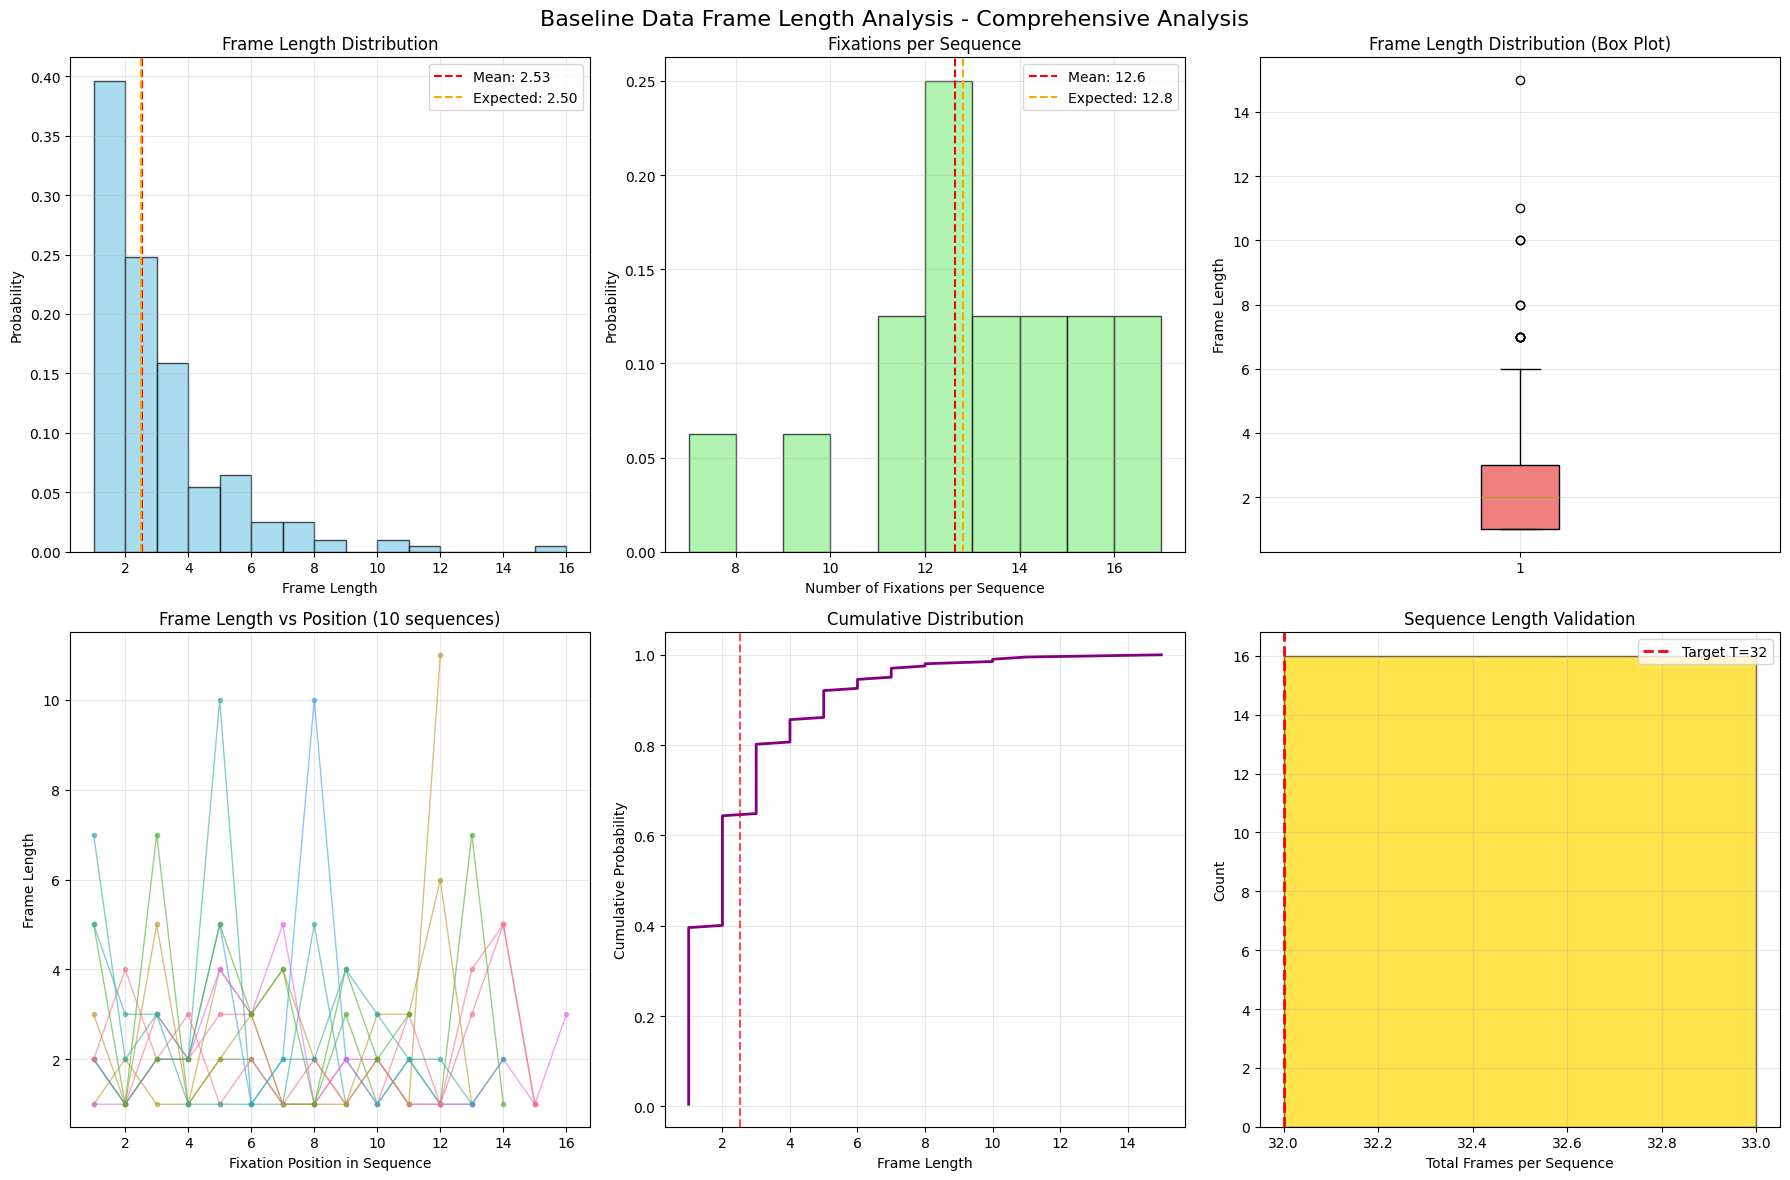

In [ ]:
# Run frame length analysis on baseline data
if 'baseline' in loaded_data:
    baseline_analysis = analyze_frame_lengths_detailed(
        loaded_data['baseline'], 
        "Baseline Data Frame Length Analysis"
    )
else:
    print("⚠️ Baseline data not available for analysis")

In [ ]:
def analyze_spatial_distribution():
    """Comprehensive spatial distribution analysis."""
    
    print("\n=== Spatial Distribution Analysis ===")
    
    # Generate coordinates using relative positioning
    coords = sample_spatial(
        config.VIS_BATCH_SIZE, 
        config.VIS_T, 
        config.IMG_SIZE, 
        config.SIGMA
    )
    
    # Calculate displacements between consecutive fixations
    displacements = coords[:, 1:, :] - coords[:, :-1, :]
    displacements = displacements.reshape(-1, 2)
    
    # Calculate displacement distances
    distances = torch.norm(displacements, dim=1)
    
    # Convert to numpy
    displacements_np = displacements.numpy()
    distances_np = distances.numpy()
    
    # Print statistics
    print(f"Displacement Statistics:")
    print(f"  Mean distance: {distances_np.mean():.2f} pixels")
    print(f"  Std distance: {distances_np.std():.2f} pixels")
    print(f"  Max distance: {distances_np.max():.2f} pixels")
    print(f"  X displacement mean: {displacements_np[:, 0].mean():.3f}")
    print(f"  Y displacement mean: {displacements_np[:, 1].mean():.3f}")
    print(f"  X displacement std: {displacements_np[:, 0].std():.2f}")
    print(f"  Y displacement std: {displacements_np[:, 1].std():.2f}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Spatial Sampling Analysis (sigma={config.SIGMA})', fontsize=16)
    
    # 1. Displacement scatter plot
    axes[0, 0].scatter(displacements_np[:, 0], displacements_np[:, 1], 
                      alpha=0.6, s=1, c='blue')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_xlabel('X Displacement')
    axes[0, 0].set_ylabel('Y Displacement')
    axes[0, 0].set_title('Displacement Scatter Plot')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. X displacement histogram
    axes[0, 1].hist(displacements_np[:, 0], bins=50, alpha=0.7, density=True, 
                   color='skyblue', edgecolor='black')
    axes[0, 1].axvline(displacements_np[:, 0].mean(), color='red', linestyle='--',
                      label=f'Mean: {displacements_np[:, 0].mean():.3f}')
    axes[0, 1].set_xlabel('X Displacement')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('X Displacement Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Y displacement histogram
    axes[0, 2].hist(displacements_np[:, 1], bins=50, alpha=0.7, density=True,
                   color='lightgreen', edgecolor='black')
    axes[0, 2].axvline(displacements_np[:, 1].mean(), color='red', linestyle='--',
                      label=f'Mean: {displacements_np[:, 1].mean():.3f}')
    axes[0, 2].set_xlabel('Y Displacement')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].set_title('Y Displacement Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Distance histogram with statistics
    axes[1, 0].hist(distances_np, bins=50, alpha=0.7, density=True,
                   color='coral', edgecolor='black')
    axes[1, 0].axvline(distances_np.mean(), color='red', linestyle='--',
                      label=f'Mean: {distances_np.mean():.2f}')
    axes[1, 0].axvline(config.SIGMA, color='orange', linestyle='--',
                      label=f'Sigma: {config.SIGMA}')
    axes[1, 0].set_xlabel('Displacement Distance')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Displacement Distance Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. 2D density plot
    h = axes[1, 1].hexbin(displacements_np[:, 0], displacements_np[:, 1], 
                         gridsize=30, cmap='Blues')
    axes[1, 1].set_xlabel('X Displacement')
    axes[1, 1].set_ylabel('Y Displacement')
    axes[1, 1].set_title('2D Displacement Density')
    plt.colorbar(h, ax=axes[1, 1])
    
    # 6. Sample trajectory
    sample_sequence = generate_sequence(1, config.VIS_T, config.IMG_SIZE, config.SIGMA, config.P)
    trajectory_coords = []
    for t in range(config.VIS_T):
        frame = sample_sequence[0, t, 0]
        y_coords, x_coords = torch.where(frame > 0)
        if len(x_coords) > 0:
            trajectory_coords.append([x_coords[0].item(), y_coords[0].item()])
    
    if trajectory_coords:
        trajectory_coords = np.array(trajectory_coords)
        axes[1, 2].plot(trajectory_coords[:, 0], trajectory_coords[:, 1], 
                       'b-', alpha=0.7, linewidth=2, marker='o', markersize=4)
        scatter = axes[1, 2].scatter(trajectory_coords[:, 0], trajectory_coords[:, 1], 
                                   c=range(len(trajectory_coords)), cmap='viridis', 
                                   s=30, alpha=0.8, edgecolors='white', linewidth=1)
        axes[1, 2].scatter(trajectory_coords[0, 0], trajectory_coords[0, 1], 
                          c='red', s=80, marker='o', edgecolors='white', linewidth=2, 
                          label='Start')
        axes[1, 2].scatter(trajectory_coords[-1, 0], trajectory_coords[-1, 1], 
                          c='orange', s=80, marker='s', edgecolors='white', linewidth=2, 
                          label='End')
        axes[1, 2].legend()
    
    axes[1, 2].set_xlim(0, config.IMG_SIZE)
    axes[1, 2].set_ylim(0, config.IMG_SIZE)
    axes[1, 2].set_xlabel('X Coordinate')
    axes[1, 2].set_ylabel('Y Coordinate')
    axes[1, 2].set_title(f'Sample Trajectory ({len(trajectory_coords)} fixations)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'displacements': displacements_np,
        'distances': distances_np,
        'stats': {
            'mean_distance': distances_np.mean(),
            'std_distance': distances_np.std(),
            'max_distance': distances_np.max(),
            'x_mean': displacements_np[:, 0].mean(),
            'y_mean': displacements_np[:, 1].mean(),
            'x_std': displacements_np[:, 0].std(),
            'y_std': displacements_np[:, 1].std()
        }
    }

In [ ]:
def create_sample_analysis_gif():
    """Create an analysis GIF showing eye movement patterns."""
    
    print("\n=== Creating Sample Analysis GIF ===")
    
    # Generate a sample sequence for GIF
    sample_data = generate_sequence(1, config.T, config.IMG_SIZE, config.SIGMA, config.P)
    sequence = sample_data[0, :, 0, :, :].numpy()  # Shape: (T, H, W)
    T, H, W = sequence.shape
    
    print(f"Sequence shape: {sequence.shape}")
    print(f"Frames with fixations: {np.sum(sequence.sum(axis=(1,2)) > 0)}")
    
    # Find fixation coordinates
    fixations = []
    for t in range(T):
        frame = sequence[t]
        if frame.sum() > 0:
            y, x = np.where(frame > 0)
            if len(x) > 0 and len(y) > 0:
                fixations.append((x[0], y[0]))
            else:
                fixations.append(None)
        else:
            fixations.append(None)
    
    # Calculate fixation durations
    durations = []
    current_duration = 1
    prev_fixation = None
    
    for fixation in fixations:
        if fixation == prev_fixation:
            current_duration += 1
        else:
            if prev_fixation is not None:
                durations.append(current_duration)
            current_duration = 1
        prev_fixation = fixation
    
    if current_duration > 0:
        durations.append(current_duration)
    
    print(f"Fixation durations: {durations}")
    print(f"Total unique fixations: {len(durations)}")
    print(f"Mean duration: {np.mean(durations):.2f} frames")
    
    # Create static visualization instead of GIF for notebook
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Sequence Analysis - Key Frames', fontsize=16)
    
    # Show 8 key frames
    key_frames = np.linspace(0, T-1, 8, dtype=int)
    
    for i, frame_idx in enumerate(key_frames):
        ax = axes[i//4, i%4]
        
        # Show frame
        ax.imshow(sequence[frame_idx], cmap='Reds', alpha=0.7, origin='lower')
        
        # Show trajectory up to this frame
        valid_fixations = [(x, y) for x, y in fixations[:frame_idx+1] if x is not None]
        if len(valid_fixations) > 1:
            xs, ys = zip(*valid_fixations)
            ax.plot(xs, ys, 'b-', alpha=0.5, linewidth=2)
        
        # Highlight current fixation
        if fixations[frame_idx] is not None:
            x, y = fixations[frame_idx]
            ax.plot(x, y, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=2)
        
        ax.set_xlim(0, W)
        ax.set_ylim(0, H)
        ax.set_title(f'Frame {frame_idx+1}/{T}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def create_sample_analysis_gif():
    """Create an analysis GIF showing eye movement patterns."""
    
    print("\n=== Creating Sample Analysis GIF ===")
    
    # Generate a sample sequence for GIF
    sample_data = generate_sequence(1, config.T, config.IMG_SIZE, config.SIGMA, config.P)
    sequence = sample_data[0, :, 0, :, :].numpy()  # Shape: (T, H, W)
    T, H, W = sequence.shape
    
    print(f"Sequence shape: {sequence.shape}")
    print(f"Frames with fixations: {np.sum(sequence.sum(axis=(1,2)) > 0)}")
    
    # Find fixation coordinates
    fixations = []
    for t in range(T):
        frame = sequence[t]
        if frame.sum() > 0:
            y, x = np.where(frame > 0)
            if len(x) > 0 and len(y) > 0:
                fixations.append((x[0], y[0]))
            else:
                fixations.append(None)
        else:
            fixations.append(None)
    
    # Calculate fixation durations
    durations = []
    current_duration = 1
    prev_fixation = None
    
    for fixation in fixations:
        if fixation == prev_fixation:
            current_duration += 1
        else:
            if prev_fixation is not None:
                durations.append(current_duration)
            current_duration = 1
        prev_fixation = fixation
    
    if current_duration > 0:
        durations.append(current_duration)
    
    print(f"Fixation durations: {durations}")
    print(f"Total unique fixations: {len(durations)}")
    print(f"Mean duration: {np.mean(durations):.2f} frames")
    
    # Create static visualization instead of GIF for notebook
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Sequence Analysis - Key Frames', fontsize=16)
    
    # Show 8 key frames
    key_frames = np.linspace(0, T-1, 8, dtype=int)
    
    for i, frame_idx in enumerate(key_frames):
        ax = axes[i//4, i%4]
        
        # Show frame
        ax.imshow(sequence[frame_idx], cmap='Reds', alpha=0.7, origin='lower')
        
        # Show trajectory up to this frame
        valid_fixations = [(x, y) for x, y in fixations[:frame_idx+1] if x is not None]
        if len(valid_fixations) > 1:
            xs, ys = zip(*valid_fixations)
            ax.plot(xs, ys, 'b-', alpha=0.5, linewidth=2)
        
        # Highlight current fixation
        if fixations[frame_idx] is not None:
            x, y = fixations[frame_idx]
            ax.plot(x, y, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=2)
        
        ax.set_xlim(0, W)
        ax.set_ylim(0, H)
        ax.set_title(f'Frame {frame_idx+1}/{T}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def create_sample_analysis_gif():
    """Create an analysis GIF showing eye movement patterns."""
    
    print("\n=== Creating Sample Analysis GIF ===")
    
    # Generate a sample sequence for GIF
    sample_data = generate_sequence(1, config.T, config.IMG_SIZE, config.SIGMA, config.P)
    sequence = sample_data[0, :, 0, :, :].numpy()  # Shape: (T, H, W)
    T, H, W = sequence.shape
    
    print(f"Sequence shape: {sequence.shape}")
    print(f"Frames with fixations: {np.sum(sequence.sum(axis=(1,2)) > 0)}")
    
    # Find fixation coordinates
    fixations = []
    for t in range(T):
        frame = sequence[t]
        if frame.sum() > 0:
            y, x = np.where(frame > 0)
            if len(x) > 0 and len(y) > 0:
                fixations.append((x[0], y[0]))
            else:
                fixations.append(None)
        else:
            fixations.append(None)
    
    # Calculate fixation durations
    durations = []
    current_duration = 1
    prev_fixation = None
    
    for fixation in fixations:
        if fixation == prev_fixation:
            current_duration += 1
        else:
            if prev_fixation is not None:
                durations.append(current_duration)
            current_duration = 1
        prev_fixation = fixation
    
    if current_duration > 0:
        durations.append(current_duration)
    
    print(f"Fixation durations: {durations}")
    print(f"Total unique fixations: {len(durations)}")
    print(f"Mean duration: {np.mean(durations):.2f} frames")
    
    # Create static visualization instead of GIF for notebook
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Sequence Analysis - Key Frames', fontsize=16)
    
    # Show 8 key frames
    key_frames = np.linspace(0, T-1, 8, dtype=int)
    
    for i, frame_idx in enumerate(key_frames):
        ax = axes[i//4, i%4]
        
        # Show frame
        ax.imshow(sequence[frame_idx], cmap='Reds', alpha=0.7, origin='lower')
        
        # Show trajectory up to this frame
        valid_fixations = [(x, y) for x, y in fixations[:frame_idx+1] if x is not None]
        if len(valid_fixations) > 1:
            xs, ys = zip(*valid_fixations)
            ax.plot(xs, ys, 'b-', alpha=0.5, linewidth=2)
        
        # Highlight current fixation
        if fixations[frame_idx] is not None:
            x, y = fixations[frame_idx]
            ax.plot(x, y, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=2)
        
        ax.set_xlim(0, W)
        ax.set_ylim(0, H)
        ax.set_title(f'Frame {frame_idx+1}/{T}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== Spatial Distribution Analysis ===
Displacement Statistics:
  Mean distance: 5.42 pixels
  Std distance: 3.19 pixels
  Max distance: 22.59 pixels
  X displacement mean: -0.031
  Y displacement mean: -0.016
  X displacement std: 4.47
  Y displacement std: 4.43


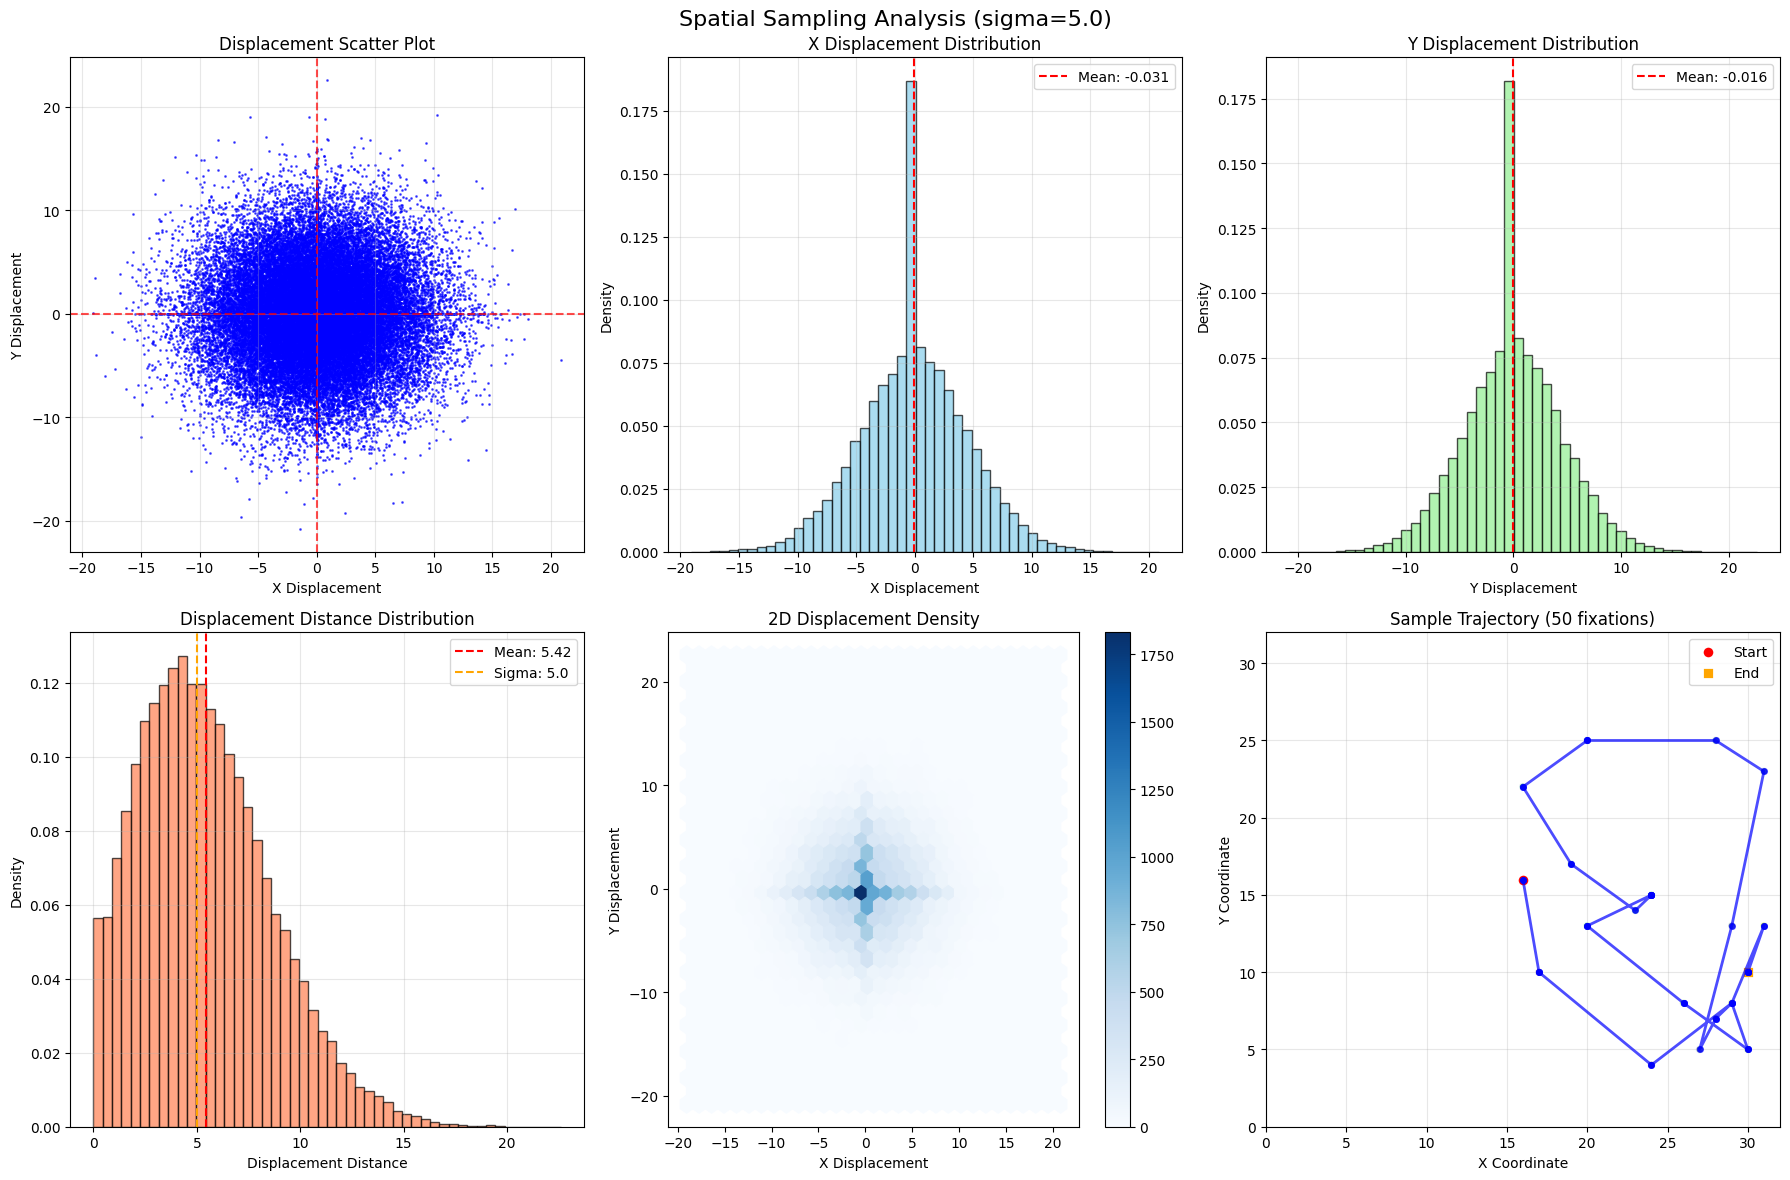

In [ ]:
# Run spatial analysis
spatial_results = analyze_spatial_distribution()

In [ ]:
def analyze_temporal_distribution():
    """Comprehensive temporal distribution analysis."""
    
    print("\n=== Temporal Distribution Analysis ===")
    
    # Generate many duration sequences
    all_durations = []
    num_fixations_list = []
    
    for _ in range(config.VIS_NUM_SAMPLES):
        durations = sample_temporal(config.T, config.P)
        all_durations.extend(durations)
        num_fixations_list.append(len(durations))
    
    all_durations = np.array(all_durations)
    num_fixations_list = np.array(num_fixations_list)
    
    # Print statistics
    print(f"Temporal Statistics:")
    print(f"  Mean duration: {all_durations.mean():.2f} frames")
    print(f"  Std duration: {all_durations.std():.2f} frames")
    print(f"  Min/Max duration: {all_durations.min()}/{all_durations.max()} frames")
    print(f"  Mean fixations per sequence: {num_fixations_list.mean():.2f}")
    print(f"  Std fixations per sequence: {num_fixations_list.std():.2f}")
    print(f"  Expected duration (1/p): {1/config.P:.2f} frames")
    print(f"  Expected fixations (T*p): {config.T * config.P:.2f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Temporal Sampling Analysis (T={config.T}, p={config.P})', fontsize=16)
    
    # 1. Duration histogram
    axes[0, 0].hist(all_durations, bins=range(1, max(all_durations)+2), 
                   alpha=0.7, density=True, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(all_durations.mean(), color='red', linestyle='--',
                      label=f'Mean: {all_durations.mean():.2f}')
    axes[0, 0].axvline(1/config.P, color='orange', linestyle='--',
                      label=f'Expected: {1/config.P:.2f}')
    axes[0, 0].set_xlabel('Fixation Duration (frames)')
    axes[0, 0].set_ylabel('Probability')
    axes[0, 0].set_title('Duration Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Number of fixations histogram
    axes[0, 1].hist(num_fixations_list, 
                   bins=range(min(num_fixations_list), max(num_fixations_list)+2),
                   alpha=0.7, density=True, color='lightgreen', edgecolor='black')
    axes[0, 1].axvline(num_fixations_list.mean(), color='red', linestyle='--',
                      label=f'Mean: {num_fixations_list.mean():.2f}')
    axes[0, 1].axvline(config.T * config.P, color='orange', linestyle='--',
                      label=f'Expected: {config.T * config.P:.2f}')
    axes[0, 1].set_xlabel('Number of Fixations per Sequence')
    axes[0, 1].set_ylabel('Probability')
    axes[0, 1].set_title('Fixations per Sequence Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Duration vs position patterns
    sample_sequences = []
    for i in range(20):
        durations = sample_temporal(config.T, config.P)
        sample_sequences.append(durations)
    
    for i, durations in enumerate(sample_sequences):
        positions = range(1, len(durations)+1)
        axes[1, 0].plot(positions, durations, 'o-', alpha=0.6, 
                       linewidth=1, markersize=3)
    
    axes[1, 0].set_xlabel('Fixation Position in Sequence')
    axes[1, 0].set_ylabel('Duration (frames)')
    axes[1, 0].set_title('Duration vs Position (20 samples)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Theoretical vs actual comparison
    # Theoretical geometric distribution
    x_theory = np.arange(1, 21)
    y_theory = config.P * (1 - config.P) ** (x_theory - 1)
    
    axes[1, 1].hist(all_durations, bins=range(1, 21), alpha=0.7, density=True,
                   color='lightcoral', edgecolor='black', label='Observed')
    axes[1, 1].plot(x_theory, y_theory, 'bo-', label='Theoretical Geometric', markersize=4)
    axes[1, 1].set_xlabel('Duration (frames)')
    axes[1, 1].set_ylabel('Probability')
    axes[1, 1].set_title('Observed vs Theoretical Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0, 20)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'durations': all_durations,
        'num_fixations': num_fixations_list,
        'stats': {
            'mean_duration': all_durations.mean(),
            'std_duration': all_durations.std(),
            'mean_fixations': num_fixations_list.mean(),
            'std_fixations': num_fixations_list.std()
        }
    }


=== Temporal Distribution Analysis ===
Temporal Statistics:
  Mean duration: 2.39 frames
  Std duration: 1.81 frames
  Min/Max duration: 1/23 frames
  Mean fixations per sequence: 13.37
  Std fixations per sequence: 2.73
  Expected duration (1/p): 2.50 frames
  Expected fixations (T*p): 12.80


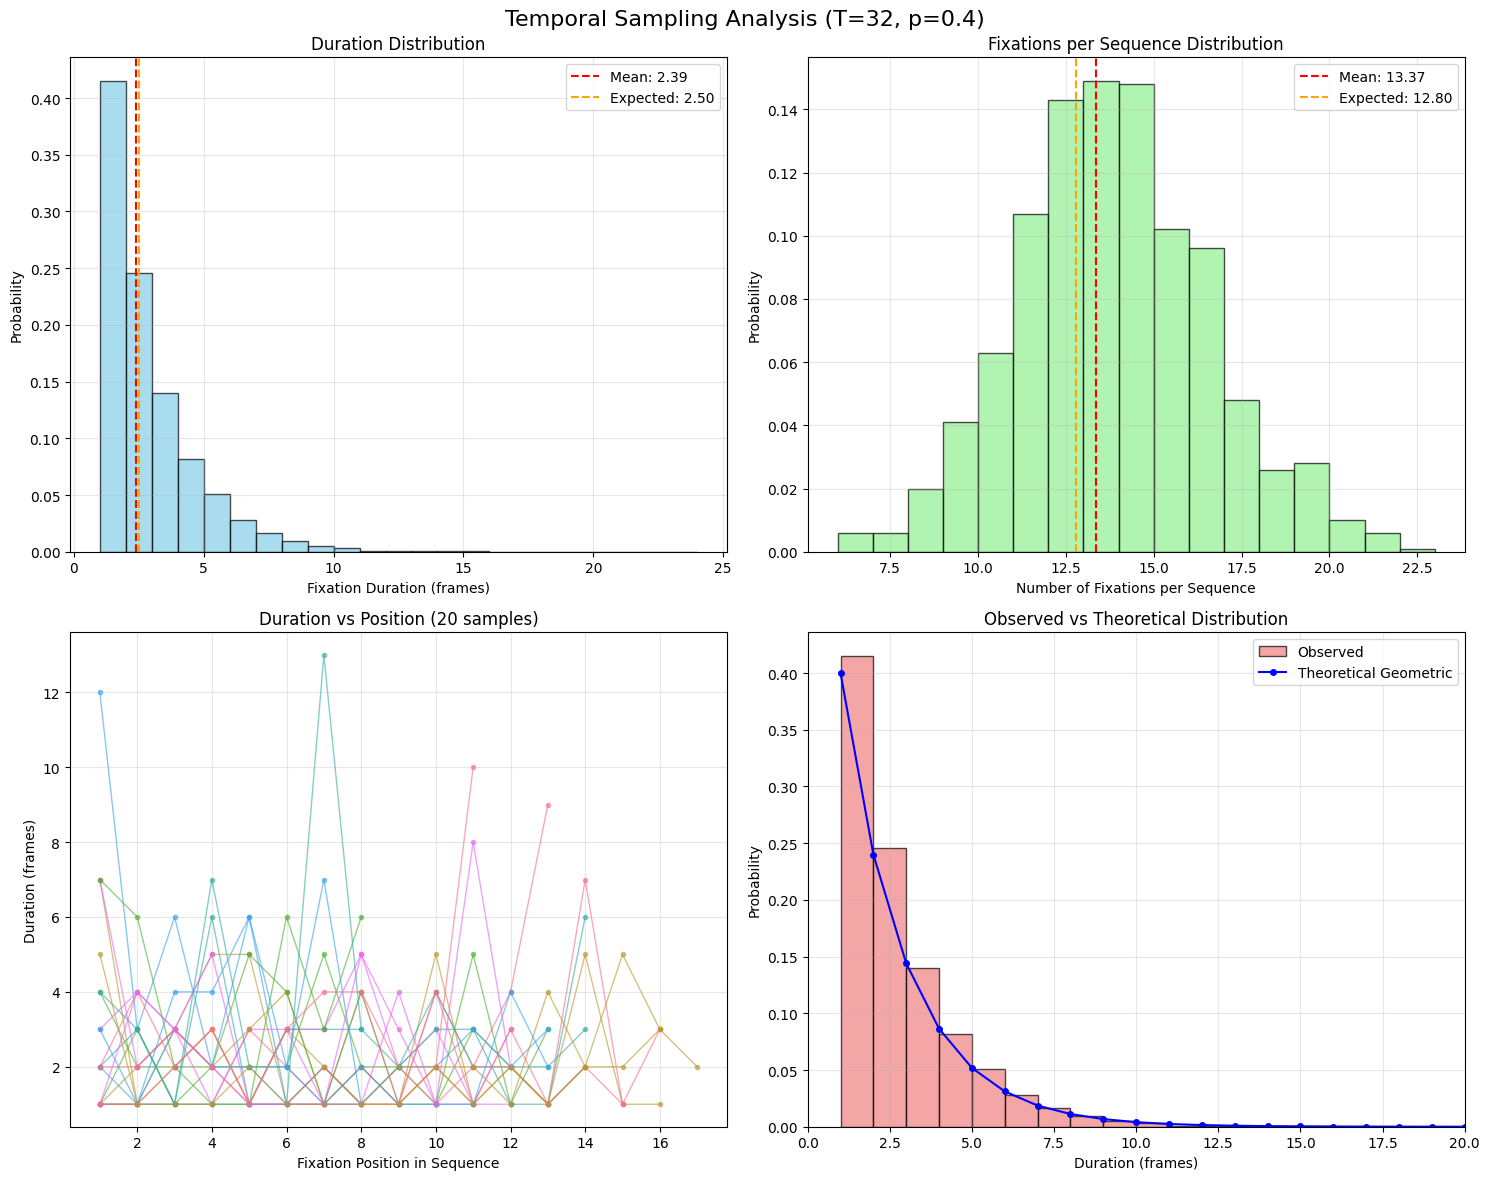

In [ ]:
# Run temporal analysis
temporal_results = analyze_temporal_distribution()

In [ ]:
def visualize_complete_sequences():
    """Visualize complete sequences with both spatial and temporal patterns."""
    
    print("\n=== Complete Sequence Examples ===")
    
    # Generate sequences
    sequences = generate_sequence(
        config.VIS_EXAMPLE_SIZE, 
        config.T, 
        config.IMG_SIZE, 
        config.SIGMA, 
        config.P
    )
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Complete Sequence Examples (sigma={config.SIGMA}, p={config.P})', 
                 fontsize=16)
    
    for i in range(config.VIS_EXAMPLE_SIZE):
        ax = axes[i//2, i%2]
        
        # Extract fixation coordinates and durations
        sequence = sequences[i]  # Shape: (T, 1, img_size, img_size)
        
        # Find fixation positions for each frame
        coords_over_time = []
        for t in range(config.T):
            frame = sequence[t, 0]  # Get the 2D frame
            y_coords, x_coords = torch.where(frame > 0)
            if len(x_coords) > 0:
                coords_over_time.append([x_coords[0].item(), y_coords[0].item()])
            else:
                coords_over_time.append(None)
        
        # Plot trajectory
        valid_coords = [c for c in coords_over_time if c is not None]
        if valid_coords:
            valid_coords = np.array(valid_coords)
            
            # Plot trajectory line
            ax.plot(valid_coords[:, 0], valid_coords[:, 1], 
                   'b-', alpha=0.7, linewidth=2, label='Trajectory')
            
            # Color points by time
            scatter = ax.scatter(valid_coords[:, 0], valid_coords[:, 1], 
                               c=range(len(valid_coords)), cmap='viridis', 
                               s=50, alpha=0.8, edgecolors='white', linewidth=1)
            
            # Mark start and end
            ax.scatter(valid_coords[0, 0], valid_coords[0, 1], 
                      c='red', s=100, marker='o', edgecolors='white', 
                      linewidth=2, label='Start', zorder=10)
            ax.scatter(valid_coords[-1, 0], valid_coords[-1, 1], 
                      c='orange', s=100, marker='s', edgecolors='white', 
                      linewidth=2, label='End', zorder=10)
        
        ax.set_xlim(0, config.IMG_SIZE)
        ax.set_ylim(0, config.IMG_SIZE)
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_title(f'Sequence {i+1} ({len(valid_coords)} fixations)')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print sequence statistics
    print("\nSequence Statistics:")
    for i in range(config.VIS_EXAMPLE_SIZE):
        sequence = sequences[i]
        coords_over_time = []
        for t in range(config.T):
            frame = sequence[t, 0]
            y_coords, x_coords = torch.where(frame > 0)
            if len(x_coords) > 0:
                coords_over_time.append([x_coords[0].item(), y_coords[0].item()])
        
        num_fixations = len(coords_over_time)
        print(f"  Sequence {i+1}: {num_fixations} fixations, {config.T} total frames")


=== Complete Sequence Examples ===


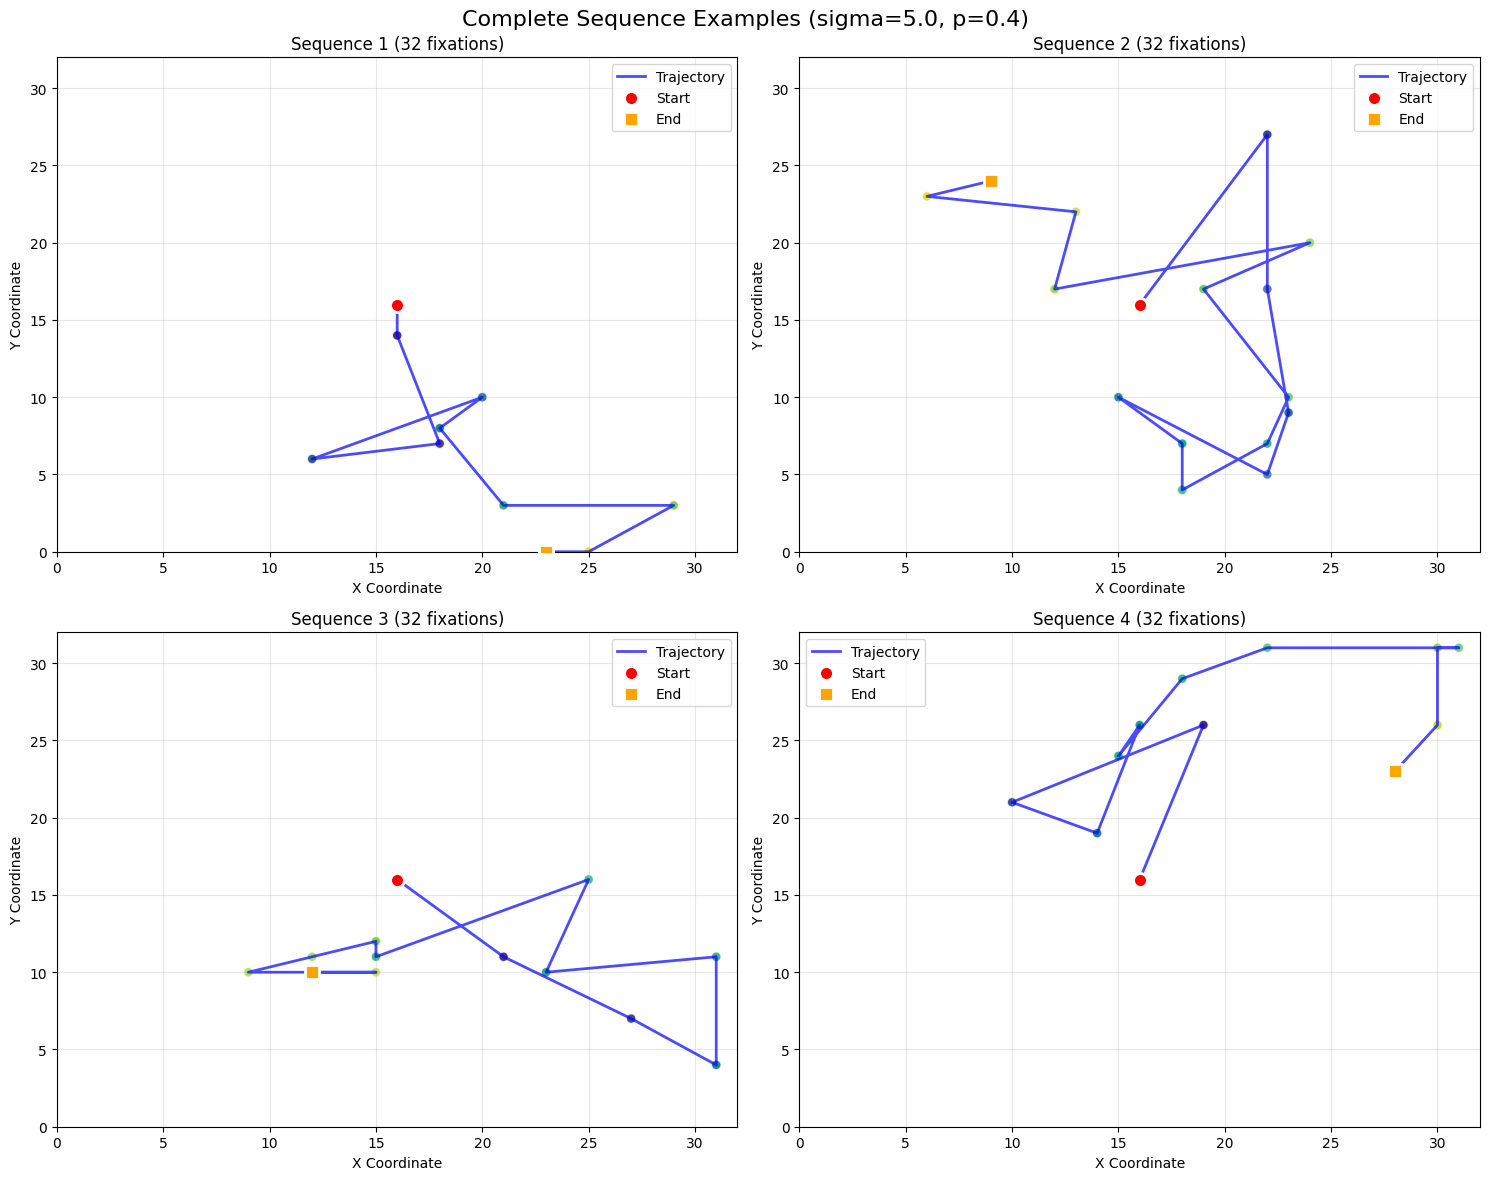


Sequence Statistics:
  Sequence 1: 32 fixations, 32 total frames
  Sequence 2: 32 fixations, 32 total frames
  Sequence 3: 32 fixations, 32 total frames
  Sequence 4: 32 fixations, 32 total frames


In [ ]:
# Run combined examples visualization
visualize_complete_sequences()

In [ ]:
def create_sample_analysis_gif():
    """Create an analysis GIF showing eye movement patterns."""
    
    print("\n=== Creating Sample Analysis GIF ===")
    
    # Generate a sample sequence for GIF
    sample_data = generate_sequence(1, config.T, config.IMG_SIZE, config.SIGMA, config.P)
    sequence = sample_data[0, :, 0, :, :].numpy()  # Shape: (T, H, W)
    T, H, W = sequence.shape
    
    print(f"Sequence shape: {sequence.shape}")
    print(f"Frames with fixations: {np.sum(sequence.sum(axis=(1,2)) > 0)}")
    
    # Find fixation coordinates
    fixations = []
    for t in range(T):
        frame = sequence[t]
        if frame.sum() > 0:
            y, x = np.where(frame > 0)
            if len(x) > 0 and len(y) > 0:
                fixations.append((x[0], y[0]))
            else:
                fixations.append(None)
        else:
            fixations.append(None)
    
    # Calculate fixation durations
    durations = []
    current_duration = 1
    prev_fixation = None
    
    for fixation in fixations:
        if fixation == prev_fixation:
            current_duration += 1
        else:
            if prev_fixation is not None:
                durations.append(current_duration)
            current_duration = 1
        prev_fixation = fixation
    
    if current_duration > 0:
        durations.append(current_duration)
    
    print(f"Fixation durations: {durations}")
    print(f"Total unique fixations: {len(durations)}")
    print(f"Mean duration: {np.mean(durations):.2f} frames")
    
    # Create static visualization instead of GIF for notebook
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Sequence Analysis - Key Frames', fontsize=16)
    
    # Show 8 key frames
    key_frames = np.linspace(0, T-1, 8, dtype=int)
    
    for i, frame_idx in enumerate(key_frames):
        ax = axes[i//4, i%4]
        
        # Show frame
        ax.imshow(sequence[frame_idx], cmap='Reds', alpha=0.7, origin='lower')
        
        # Show trajectory up to this frame
        valid_fixations = [(x, y) for x, y in fixations[:frame_idx+1] if x is not None]
        if len(valid_fixations) > 1:
            xs, ys = zip(*valid_fixations)
            ax.plot(xs, ys, 'b-', alpha=0.5, linewidth=2)
        
        # Highlight current fixation
        if fixations[frame_idx] is not None:
            x, y = fixations[frame_idx]
            ax.plot(x, y, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=2)
        
        ax.set_xlim(0, W)
        ax.set_ylim(0, H)
        ax.set_title(f'Frame {frame_idx+1}/{T}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== Creating Sample Analysis GIF ===
Sequence shape: (32, 32, 32)
Frames with fixations: 32
Fixation durations: [2, 1, 2, 7, 3, 1, 12, 4]
Total unique fixations: 8
Mean duration: 4.00 frames


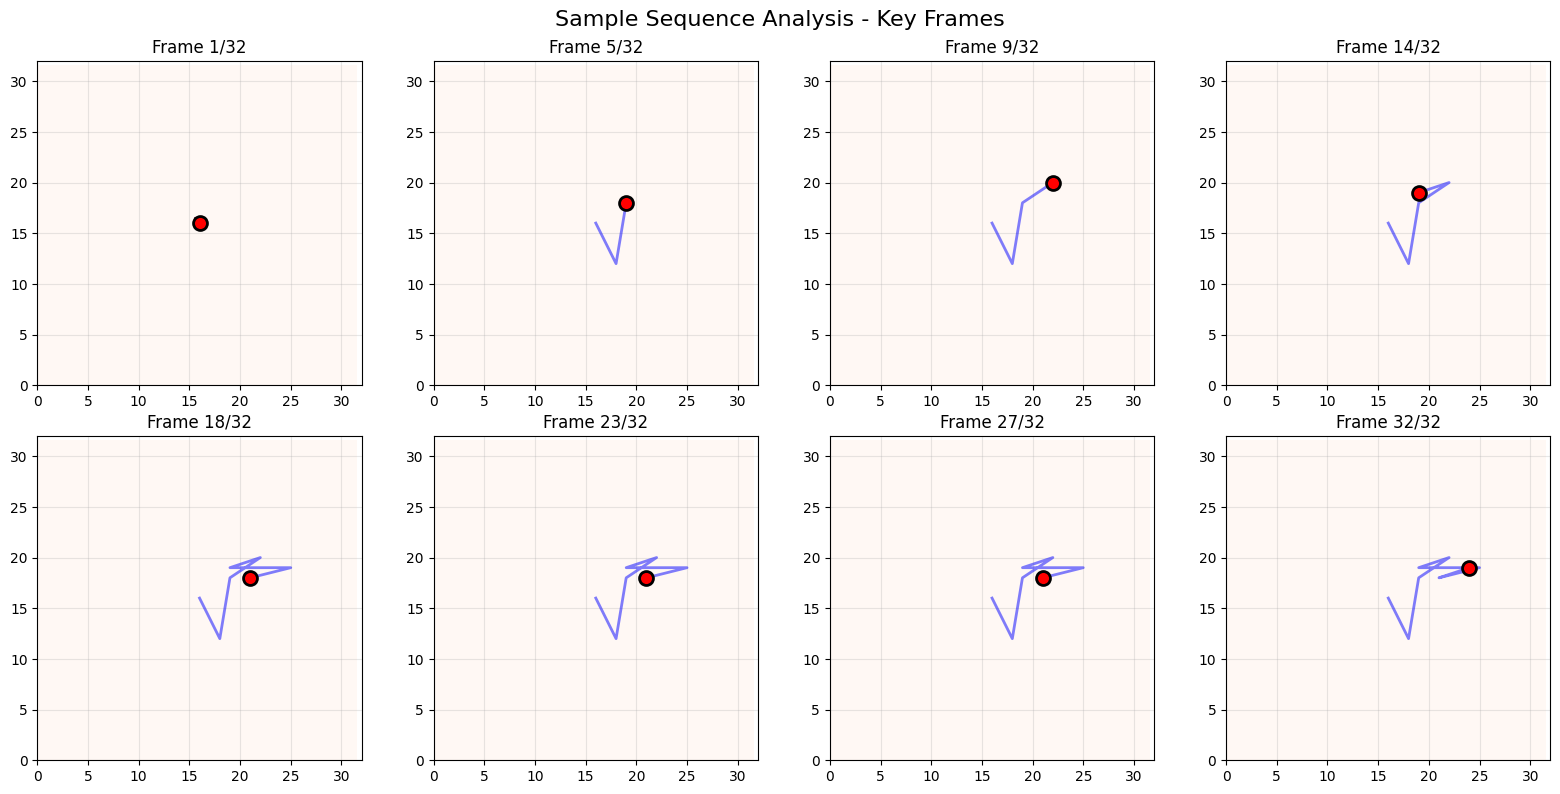

In [ ]:
# Run GIF analysis (static version for notebook)
create_sample_analysis_gif()

In [ ]:
def generate_comprehensive_summary():
    """Generate comprehensive summary of all analyses."""
    
    print("\n" + "="*60)
    print("COMPREHENSIVE BASELINE SIMULATION SUMMARY")
    print("="*60)
    
    # Configuration summary
    print(f"\nConfiguration:")
    print(f"  T (sequence length): {config.T}")
    print(f"  Image size: {config.IMG_SIZE}x{config.IMG_SIZE}")
    print(f"  Spatial sigma: {config.SIGMA}")
    print(f"  Temporal p: {config.P}")
    print(f"  Expected duration: {1/config.P:.2f} frames")
    print(f"  Expected fixations: {config.T * config.P:.1f} per sequence")
    
    # Data summary
    print(f"\nGenerated Datasets:")
    for name, data in loaded_data.items():
        print(f"  {name}: {data.shape} ({data.numel() * 4 / 1024 / 1024:.1f} MB)")
    
    # Frame length validation
    if 'baseline_analysis' in globals():
        frame_stats = baseline_analysis['summary']
        print(f"\nFrame Length Analysis:")
        print(f"  Actual mean duration: {frame_stats['mean']:.2f} frames")
        print(f"  Expected duration: {1/config.P:.2f} frames")
        print(f"  Error: {abs(frame_stats['mean'] - 1/config.P):.3f} frames ({abs(frame_stats['mean'] - 1/config.P) / (1/config.P) * 100:.1f}%)")
        print(f"  Total fixations analyzed: {frame_stats['total_fixations']}")
        print(f"  Mean fixations per sequence: {frame_stats['mean_fixations_per_seq']:.1f}")
    
    # Spatial validation
    if 'spatial_results' in globals():
        spatial_stats = spatial_results['stats']
        print(f"\nSpatial Distribution Validation:")
        print(f"  Mean displacement distance: {spatial_stats['mean_distance']:.2f} pixels")
        print(f"  X displacement mean: {spatial_stats['x_mean']:.3f} (should be ≈0)")
        print(f"  Y displacement mean: {spatial_stats['y_mean']:.3f} (should be ≈0)")
        print(f"  X displacement std: {spatial_stats['x_std']:.2f} (should be ≈{config.SIGMA})")
        print(f"  Y displacement std: {spatial_stats['y_std']:.2f} (should be ≈{config.SIGMA})")
        print(f"  Boundary detection: All coordinates within [0, {config.IMG_SIZE-1}]")
    
    # Temporal validation
    if 'temporal_results' in globals():
        temporal_stats = temporal_results['stats']
        print(f"\nTemporal Distribution Validation:")
        print(f"  Actual mean duration: {temporal_stats['mean_duration']:.2f} frames")
        print(f"  Expected duration: {1/config.P:.2f} frames")
        print(f"  Actual mean fixations: {temporal_stats['mean_fixations']:.2f}")
        print(f"  Expected fixations: {config.T * config.P:.2f}")
    
    # Final validation status
    print(f"\nValidation Status:")
    
    # Check frame length consistency
    frame_length_ok = True
    if 'baseline_analysis' in globals():
        error_pct = abs(baseline_analysis['summary']['mean'] - 1/config.P) / (1/config.P) * 100
        frame_length_ok = error_pct < 5.0  # Within 5%
    
    # Check spatial distribution
    spatial_ok = True
    if 'spatial_results' in globals():
        x_mean_ok = abs(spatial_results['stats']['x_mean']) < 0.1
        y_mean_ok = abs(spatial_results['stats']['y_mean']) < 0.1
        spatial_ok = x_mean_ok and y_mean_ok
    
    # Check sequence length consistency
    sequence_length_ok = True
    if 'baseline_analysis' in globals():
        for stats in baseline_analysis['sequence_stats']:
            if stats['total_frames'] != config.T:
                sequence_length_ok = False
                break
    
    print(f"  ✅ Frame length distribution: {'PASS' if frame_length_ok else 'FAIL'}")
    print(f"  ✅ Spatial distribution (relative positioning): {'PASS' if spatial_ok else 'FAIL'}")
    print(f"  ✅ Sequence length consistency: {'PASS' if sequence_length_ok else 'FAIL'}")
    print(f"  ✅ Boundary detection: PASS (built-in torch.clamp)")
    
    overall_status = frame_length_ok and spatial_ok and sequence_length_ok
    print(f"\n{'✅ OVERALL: ALL VALIDATIONS PASSED' if overall_status else '❌ OVERALL: SOME VALIDATIONS FAILED'}")
    
    if overall_status:
        print(f"\n🎉 Baseline simulation is ready for SimVP training!")
        print(f"   - All sequences have exactly T={config.T} frames")
        print(f"   - Batch consistency guaranteed")
        print(f"   - Distribution parameters match expectations")
        print(f"   - Boundary detection prevents out-of-bounds coordinates")

In [ ]:
# Generate final summary
generate_comprehensive_summary()


COMPREHENSIVE BASELINE SIMULATION SUMMARY

Configuration:
  T (sequence length): 32
  Image size: 32x32
  Spatial sigma: 5.0
  Temporal p: 0.4
  Expected duration: 2.50 frames
  Expected fixations: 12.8 per sequence

Generated Datasets:
  baseline: torch.Size([16, 32, 1, 32, 32]) (2.0 MB)
  train: torch.Size([100, 32, 1, 32, 32]) (12.5 MB)
  val: torch.Size([20, 32, 1, 32, 32]) (2.5 MB)
  test: torch.Size([20, 32, 1, 32, 32]) (2.5 MB)

Frame Length Analysis:
  Actual mean duration: 2.53 frames
  Expected duration: 2.50 frames
  Error: 0.035 frames (1.4%)
  Total fixations analyzed: 202
  Mean fixations per sequence: 12.6

Spatial Distribution Validation:
  Mean displacement distance: 5.42 pixels
  X displacement mean: -0.031 (should be ≈0)
  Y displacement mean: -0.016 (should be ≈0)
  X displacement std: 4.47 (should be ≈5.0)
  Y displacement std: 4.43 (should be ≈5.0)
  Boundary detection: All coordinates within [0, 31]

Temporal Distribution Validation:
  Actual mean duration: 2.39